# CoLeaf CNN

## Setup

### Imports and constants

In [1]:
import os
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from trainer import CoLeafTrainer
from dataset import CoLeafDataset, CoLeafSubset
from network import Net

In [2]:
IMG_SIZE        = 224
BATCH_SIZE      = 64
WORKERS         = 4
EPOCHS          = 50
LR              = 0.001
PATIENCE        = 10
DELTA           = 0
N_SPLIT         = 6
TEST_SIZE       = 0.2

MODEL_VERSION   = "v1"
DATASET_PATH    = "./CoLeaf DATASET"
DATASET_OUTPUT  = './output/datasets'
MODEL_OUTPUT    = "./output/models"
METRICS_OUTPUT  = "./output/metrics"
GRAPHS_OUTPUT   = "./output/graphs"

In [3]:
os.makedirs(DATASET_OUTPUT, exist_ok=True)
os.makedirs(MODEL_OUTPUT, exist_ok=True)
os.makedirs(GRAPHS_OUTPUT, exist_ok=True)
os.makedirs(METRICS_OUTPUT, exist_ok=True)

### Device, dataset and cross-validation

In [4]:
skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=42)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
print("Loading dataset...")
dataset: CoLeafDataset = torch.load(os.path.join(DATASET_OUTPUT, "dataset.pt"), weights_only=False)

print(f"Total images: {len(dataset)}")
print("Splitting dataset into train and test sets...")

train_indices, test_indices = train_test_split(
    range(len(dataset)),
    test_size=TEST_SIZE, 
    random_state=42,
    stratify=dataset.labels
)

train_dataset = CoLeafSubset(dataset, train_indices)
test_dataset = CoLeafSubset(dataset, test_indices)

print(f"Train images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")

Loading dataset...
Total images: 1006
Splitting dataset into train and test sets...
Train images: 804
Test images: 202


## Data overview

### Number of images per class

In [7]:
def num_img(dataset: CoLeafDataset | CoLeafSubset):
    im = [dataset.labels.count(i) for i in range(len(dataset.classes))]
    
    return pd.DataFrame({'Class': dataset.classes, 'Number of images': im})

In [8]:
def plot_num_img(df: pd.DataFrame, dataset: str):
    df_sorted = df.sort_values(by="Number of images", ascending=False)
    colors = sns.color_palette('tab20', len(df_sorted))
    sns.set_theme(style="whitegrid")
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f'Image distribution per class in {dataset}', fontsize=20)
    
    # Bar chart
    ax_bar = sns.barplot(ax=axes[0], x="Class", y="Number of images", data=df_sorted, palette=colors, hue="Class", legend=False)
    for p in ax_bar.patches:
        ax_bar.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), # type: ignore
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), 
                    textcoords='offset points')
        
    axes[0].tick_params(axis='x', rotation=45)

    # Pie chart
    axes[1].pie(df_sorted["Number of images"], labels=df_sorted["Class"], autopct='%1.1f%%', startangle=140, colors=colors)
    axes[1].axis('equal') 

    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(GRAPHS_OUTPUT, f'num img in {dataset}.png'))

#### Full dataset

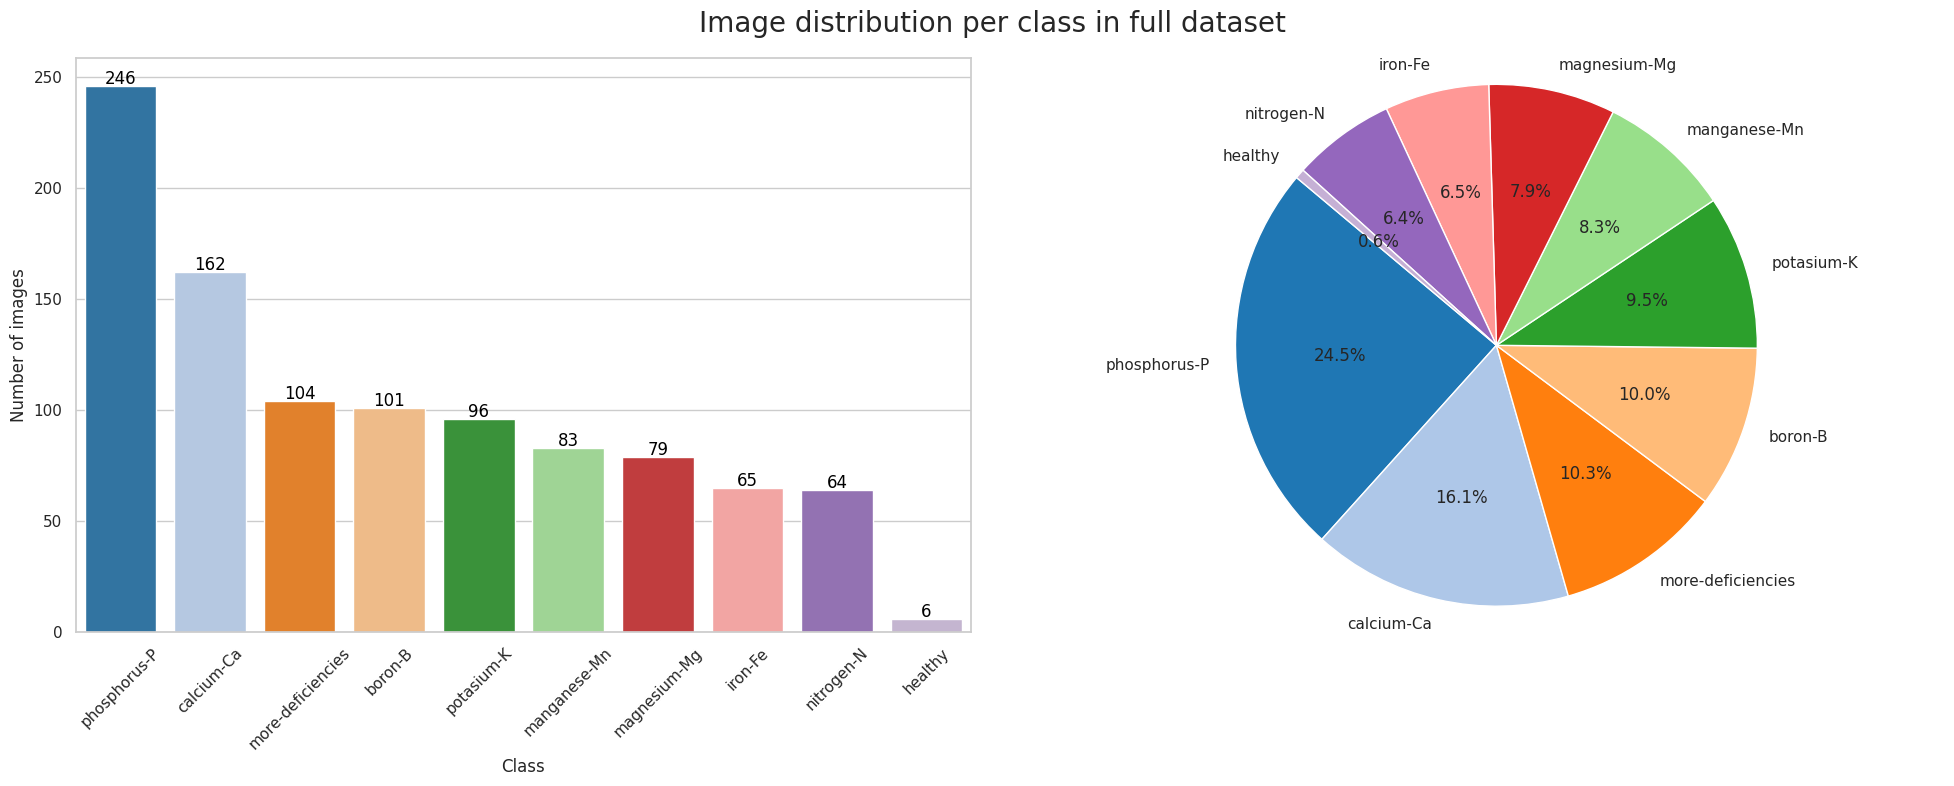

<Figure size 640x480 with 0 Axes>

In [9]:
d_df = num_img(dataset)
plot_num_img(d_df, "full dataset")

#### Train split

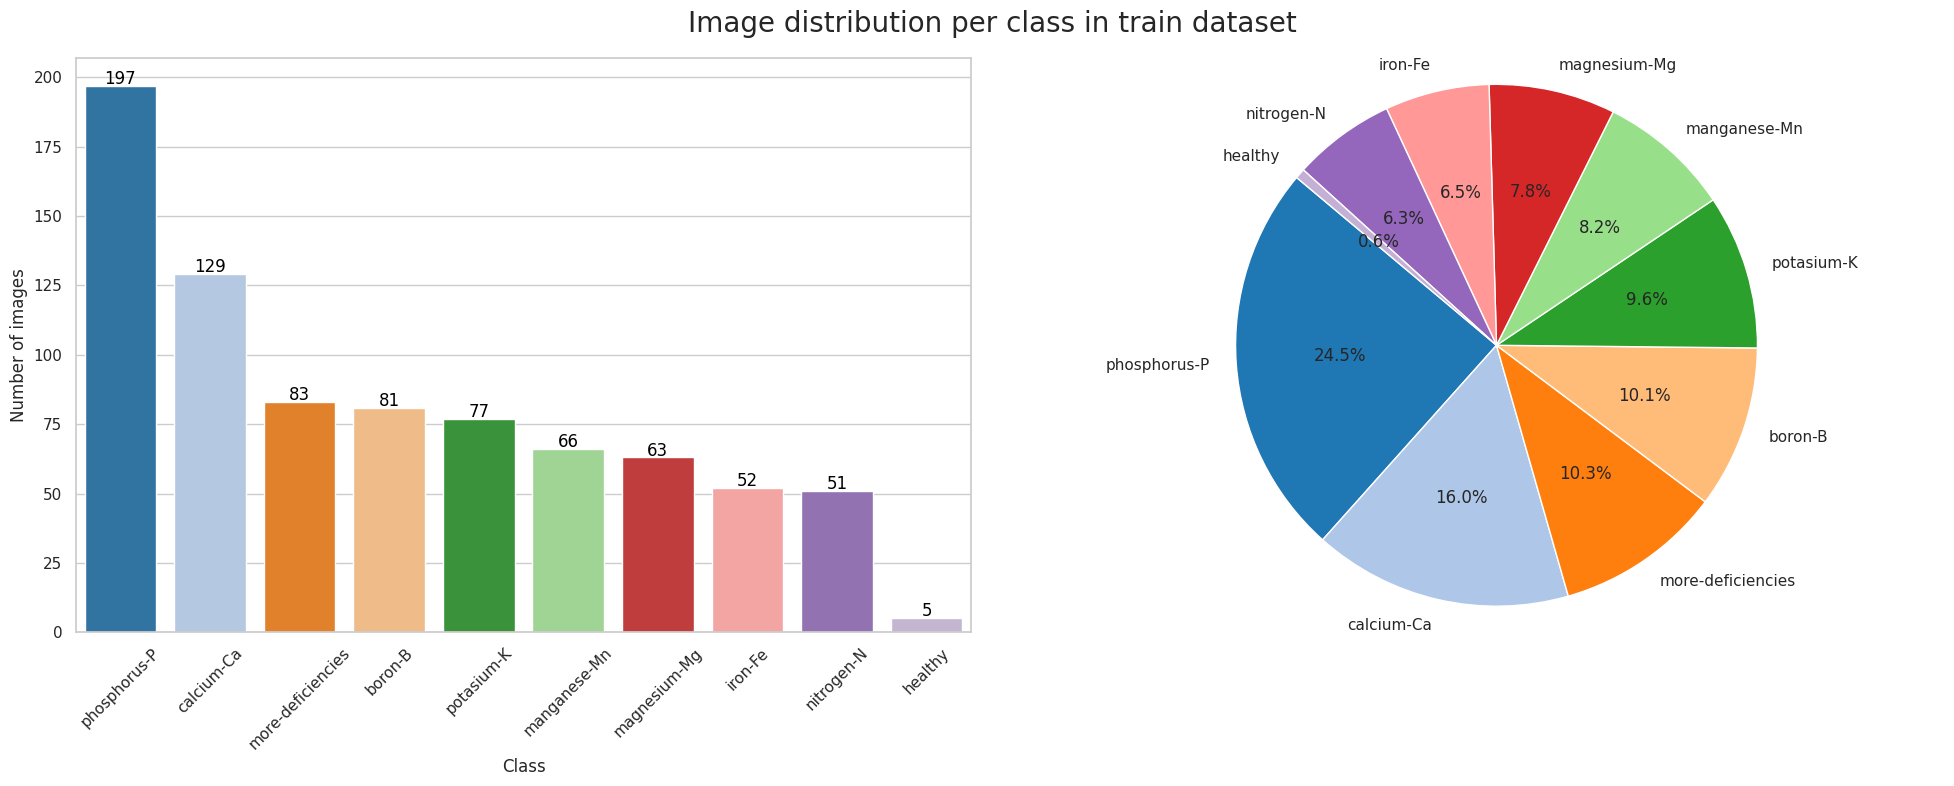

<Figure size 640x480 with 0 Axes>

In [10]:
t_df = num_img(train_dataset)
plot_num_img(t_df, "train dataset")

#### Test split

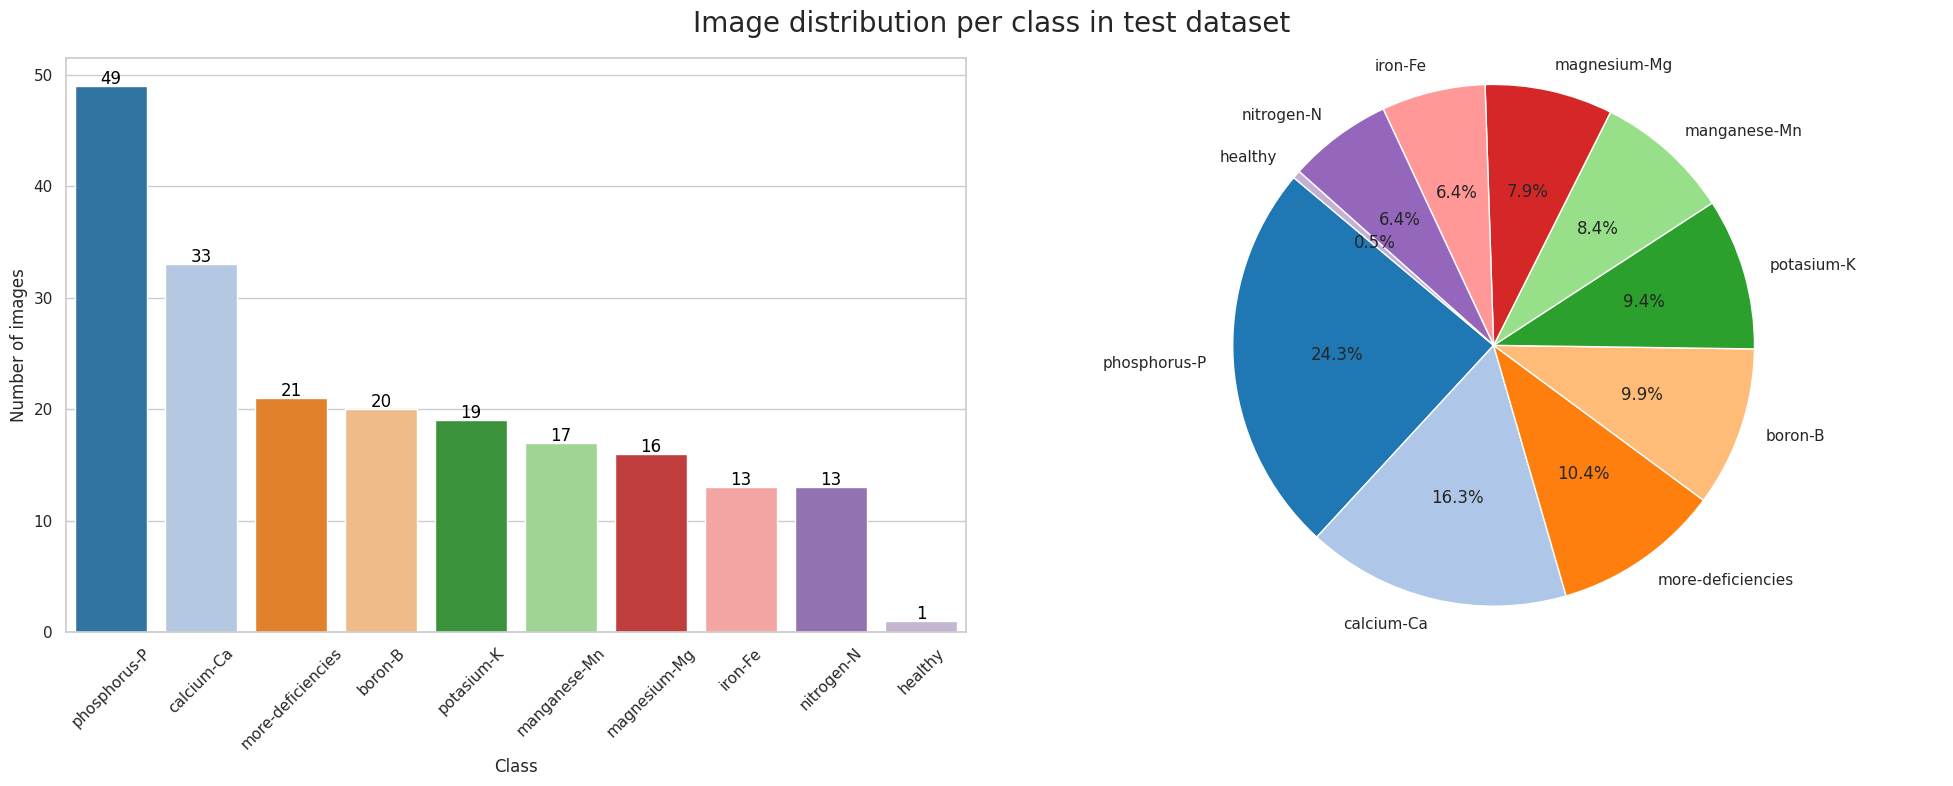

<Figure size 640x480 with 0 Axes>

In [11]:
v_df = num_img(test_dataset)
plot_num_img(v_df, "test dataset")

### Data visualization

In [12]:
def vis(dataset: CoLeafDataset | CoLeafSubset):
    classes = dataset.classes
    
    random_images = []
    for i in range(len(classes)):
        indices = [j for j, label in enumerate(dataset.labels) if label == i]
        random_index = np.random.choice(indices)
        img, _ = dataset[random_index]
        
        random_images.append(img)

    n_cols = 5
    n_rows = (len(classes) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
    axes = axes.flatten()

    for i, img in enumerate(random_images):
        ax = axes[i]
        img = transforms.ToPILImage()(img)
        ax.imshow(img)
        ax.set_title(classes[i], fontsize=12)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(GRAPHS_OUTPUT, 'vis.png'))
    plt.show()

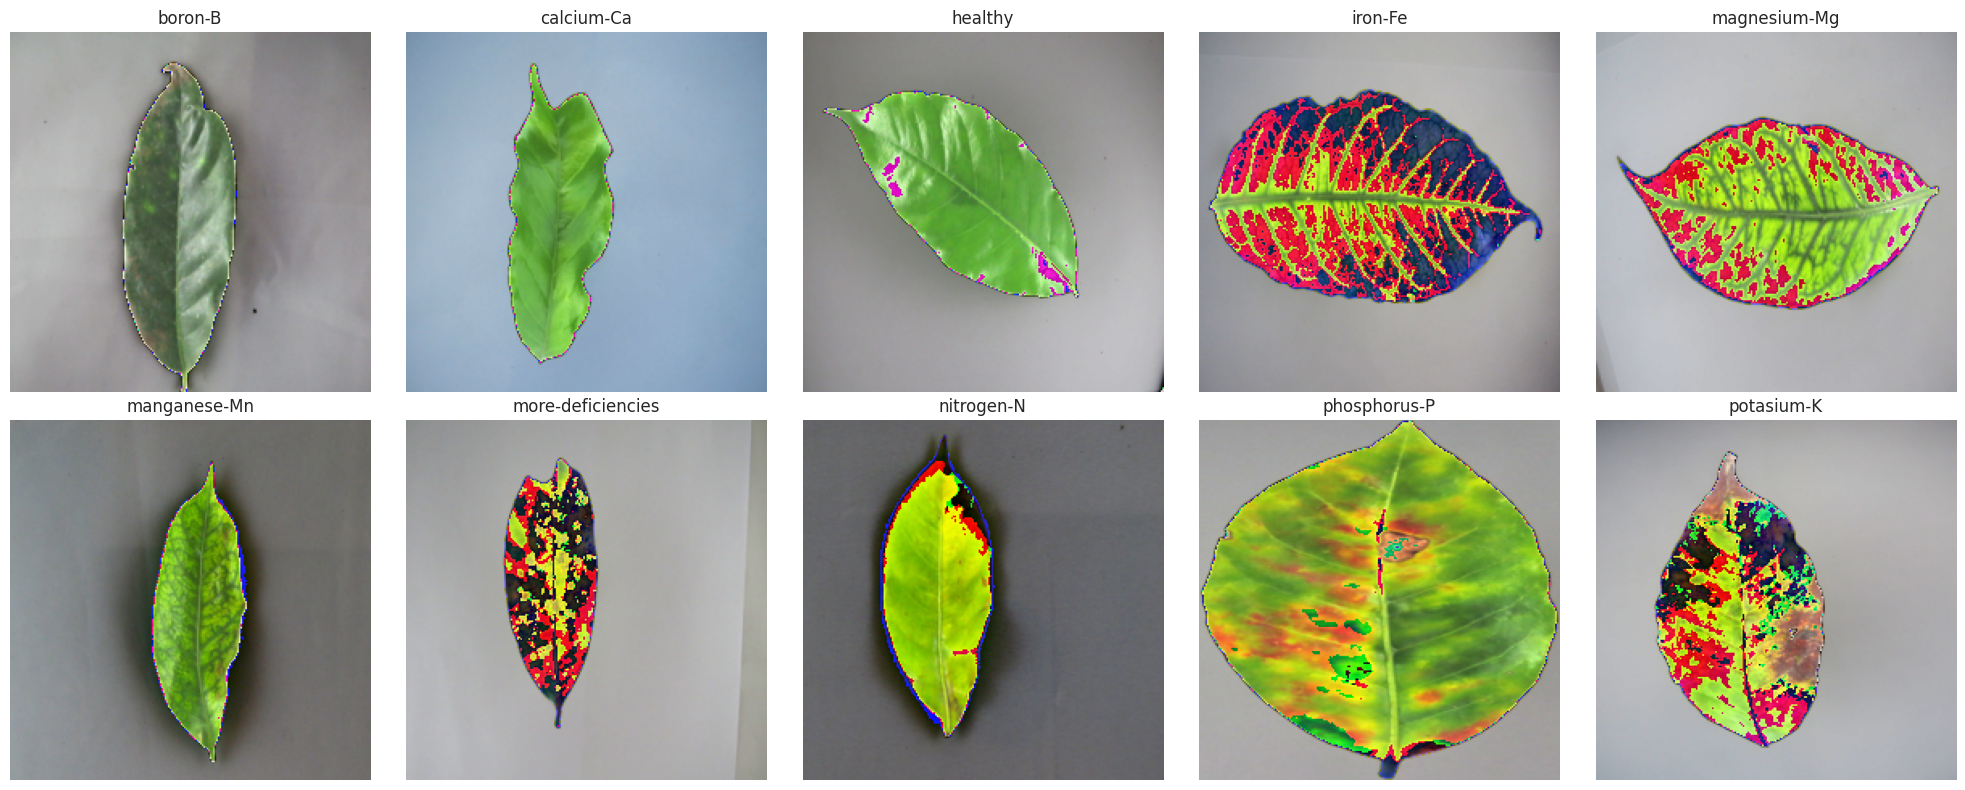

In [13]:
vis(dataset)

## Training

### Train and save results

In [14]:
net = Net().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR)

In [15]:
epoch_m = []
splits_data = []

for fold, (train_idx, val_idx) in tqdm(enumerate(skf.split(dataset.images, dataset.labels)), total=N_SPLIT, desc="Folds"):
    splits_data.append({'index': train_idx, 'iteration': fold, 'type': 'Training'})
    splits_data.append({'index': val_idx, 'iteration': fold, 'type': 'Testing'})
    
    train_subset = CoLeafSubset(dataset, train_idx)
    val_subset = CoLeafSubset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

    trainer = CoLeafTrainer(
        model=net,
        train_loader=train_loader,
        val_loader=val_loader,
        loss_function=loss_function,
        optimizer=optimizer,
        device=device,
        epochs=EPOCHS,
        patience=PATIENCE,
        delta=DELTA
    )

    trainer.train()
    trainer.save_model(os.path.join(MODEL_OUTPUT, f"model_fold_{fold+1}_{MODEL_VERSION}.pth"))
    for m in trainer.metrics:
        m['fold'] = fold
        epoch_m.append(m)
        
epoch_metrics = pd.DataFrame(epoch_m)
epoch_metrics.to_csv(os.path.join(METRICS_OUTPUT, f"epoch_metrics_{MODEL_VERSION}.csv"), header=True, sep=';')
splits_df = pd.DataFrame(splits_data).explode('index')
splits_df.to_csv(os.path.join(METRICS_OUTPUT, f"splits_data_{MODEL_VERSION}.csv"), header=True, sep=';')

Folds:   0%|          | 0/6 [00:00<?, ?it/s]

### Visualization


#### Load data

In [ ]:
epoch_metrics = pd.read_csv(os.path.join(METRICS_OUTPUT, f"epoch_metrics_{MODEL_VERSION}.csv"), sep=';')
splits_df = pd.read_csv(os.path.join(METRICS_OUTPUT, f"splits_data_{MODEL_VERSION}.csv"), sep=';')

#### Cross-validation splits

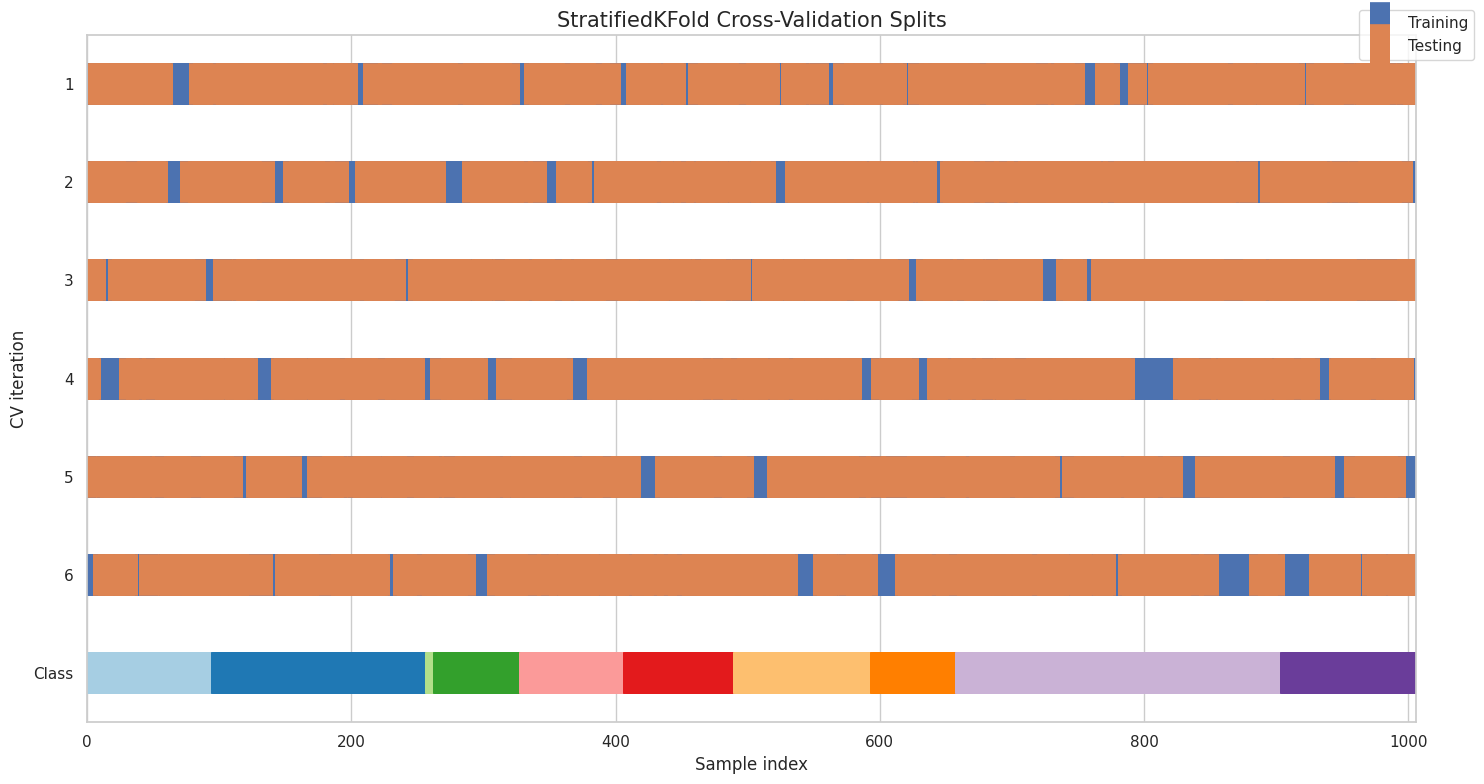

In [48]:
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(15, 8))
splits_df = splits_df.explode('index')

sns.scatterplot(
    data=splits_df,
    x='index',
    y='iteration',
    hue='type',
    marker='_',
    s=200,
    linewidth=30, 
    ax=ax,
    legend=True
)

# Plot the class distribution
sns.scatterplot(
    x=range(len(dataset.labels)),
    y=[N_SPLIT] * len(dataset.labels),
    hue=dataset.labels,
    palette='Paired',
    marker='_',
    s=200,
    linewidth=30,
    ax=ax,
    legend=False
)

# Formatting    
ax.set_yticks(np.arange(N_SPLIT + 1))
ax.set_yticklabels([str(i) for i in range(1, N_SPLIT + 1)] + ["Class"])
ax.set_xlabel("Sample index")
ax.set_ylabel("CV iteration")
ax.set_title("StratifiedKFold Cross-Validation Splits", fontsize=15)
ax.set_ylim(N_SPLIT + 0.5, -0.5)
ax.set_xlim(0, len(dataset.labels))
ax.legend(title="")
sns.move_legend(ax, "center", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

### Model loss and accuracy

In [16]:
fold_df = epoch_metrics.groupby('fold', as_index=False).agg(
    train_loss=('train_loss', 'mean'),
    train_acc=('train_acc', 'mean'),
    val_loss=('val_loss', 'mean'),
    val_acc=('val_acc', 'mean'),
)

total = fold_df.loc[:, fold_df.columns != 'fold'].agg('mean')
display(total)

train_loss    0.242443
train_acc     0.922209
val_loss      0.382426
val_acc       0.875930
dtype: float64

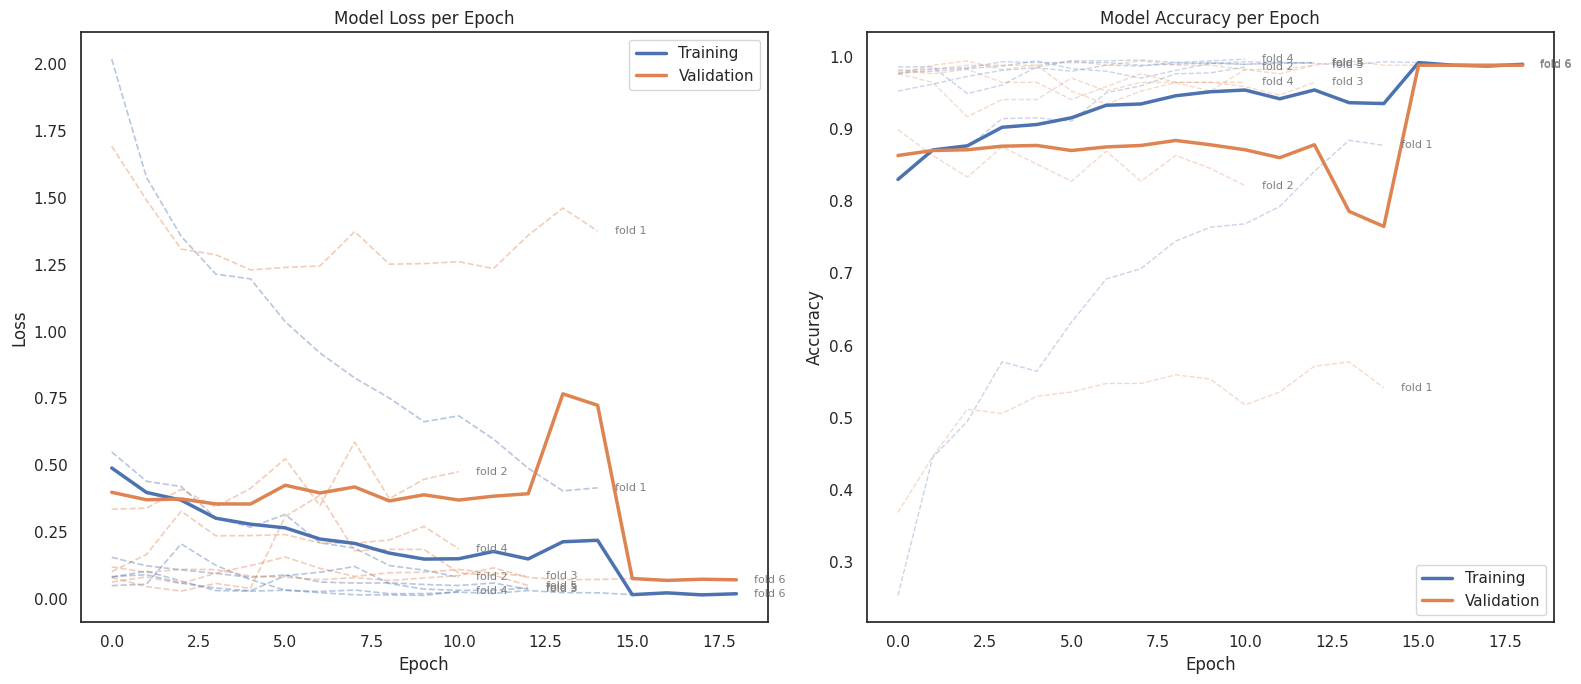

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.set_theme(style="white")

# Melt the DataFrame to a long format for Seaborn
metrics_melted = pd.melt(
    epoch_metrics,
    id_vars=["epoch", "fold"],
    value_vars=["train_loss", "val_loss", "train_acc", "val_acc"],
)

# Split variable into metric type and data type
metrics_melted[["type", "metric"]] = metrics_melted["variable"].str.split(
    "_", expand=True
)
metrics_melted["type"] = metrics_melted["type"].map(
    {"train": "Training", "val": "Validation"}
)

# Separate loss and accuracy data
df_loss = metrics_melted[metrics_melted["metric"] == "loss"]
df_acc = metrics_melted[metrics_melted["metric"] == "acc"]

# --- Loss Plot ---
# Plot each fold's loss with low opacity
sns.lineplot(
    data=df_loss,
    x="epoch",
    y="value",
    hue="type",
    units="fold",
    estimator=None,
    lw=1.2,
    alpha=0.4,
    ax=axes[0],
    legend=False,
    linestyle="--",
)
# Plot the mean loss across folds (seaborn does this by default)
sns.lineplot(data=df_loss, x="epoch", y="value", hue="type", lw=2.5, ax=axes[0], errorbar=None)
axes[0].set_title("Model Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend(title="")

# --- Accuracy Plot ---
# Plot each fold's accuracy with low opacity
sns.lineplot(
    data=df_acc,
    x="epoch",
    y="value",
    hue="type",
    units="fold",
    estimator=None,
    lw=1,
    alpha=0.3,
    ax=axes[1],
    legend=False,
    linestyle="--",
)
# Plot the mean accuracy across folds
sns.lineplot(data=df_acc, x="epoch", y="value", hue="type", lw=2.5, ax=axes[1], errorbar=None)
axes[1].set_title("Model Accuracy per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend(title="")

for fold_num in epoch_metrics['fold'].unique():
    # Get last epoch data for the current fold
    last_epoch_loss = df_loss[df_loss['fold'] == fold_num].groupby('type').last().reset_index()
    last_epoch_acc = df_acc[df_acc['fold'] == fold_num].groupby('type').last().reset_index()
    
    # Add text for loss plot
    for _, row in last_epoch_loss.iterrows():
        axes[0].text(row['epoch'] + 0.5, row['value'], f"fold {fold_num + 1}", fontsize=8, color='grey', va='center')
    
    # Add text for accuracy plot
    for _, row in last_epoch_acc.iterrows():
        axes[1].text(row['epoch'] + 0.5, row['value'], f"fold {fold_num + 1}", fontsize=8, color='grey', va='center')

plt.tight_layout()
plt.savefig(os.path.join(GRAPHS_OUTPUT, f"model_performance_{MODEL_VERSION}.png"))
plt.show()

## Testing

### Test and save results

In [34]:
net = Net().to(device)
net.load_state_dict(torch.load(os.path.join(MODEL_OUTPUT, f"model_fold_6_{MODEL_VERSION}.pth")))

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

In [35]:
net.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for data in tqdm(test_loader, desc="Evaluating..."):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        probs = torch.softmax(outputs, dim=1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=dataset.classes, output_dict=True)
all_probs  = np.array(all_probs)
all_labels = np.array(all_labels)
y_true = label_binarize(all_labels, classes=list(range(len(dataset.classes))))    
df_report = pd.DataFrame(report).transpose()
df_report['class'] = df_report.index
df_report.reset_index(drop=True, inplace=True)

df_report.to_csv(os.path.join(METRICS_OUTPUT, f"classification_report_{MODEL_VERSION}.csv"), sep=';')
np.save(os.path.join(METRICS_OUTPUT, f"confusion_matrix_{MODEL_VERSION}.npy"), cm)
np.save(os.path.join(METRICS_OUTPUT, f"all_probs_{MODEL_VERSION}.npy"), all_probs)
np.save(os.path.join(METRICS_OUTPUT, f"y_true{MODEL_VERSION}.npy"), y_true)

Evaluating...:   0%|          | 0/4 [00:00<?, ?it/s]

### Load results

In [ ]:
df_report = pd.read_csv(os.path.join(METRICS_OUTPUT, f"classification_report_{MODEL_VERSION}.csv"), sep=';')

In [ ]:
cm = np.load(os.path.join(METRICS_OUTPUT, f"confusion_matrix_{MODEL_VERSION}.npy"))

In [ ]:
all_probs = np.load(os.path.join(METRICS_OUTPUT, f"all_probs_{MODEL_VERSION}.npy"))
y_true = np.load(os.path.join(METRICS_OUTPUT, f"y_true{MODEL_VERSION}.npy"))

### Visualization

#### Classification report

In [36]:
display(df_report)

,precision,recall,f1-score,support,class
0,1.000000,1.00000,1.000000,20.00000,boron-B
1,1.000000,1.00000,1.000000,33.00000,calcium-Ca
2,1.000000,1.00000,1.000000,1.00000,healthy
3,0.928571,1.00000,0.962963,13.00000,iron-Fe
4,1.000000,0.93750,0.967742,16.00000,magnesium-Mg
5,1.000000,1.00000,1.000000,17.00000,manganese-Mn
6,1.000000,1.00000,1.000000,21.00000,more-deficiencies
7,1.000000,1.00000,1.000000,13.00000,nitrogen-N
8,1.000000,1.00000,1.000000,49.00000,phosphorus-P
9,1.000000,1.00000,1.000000,19.00000,potasium-K


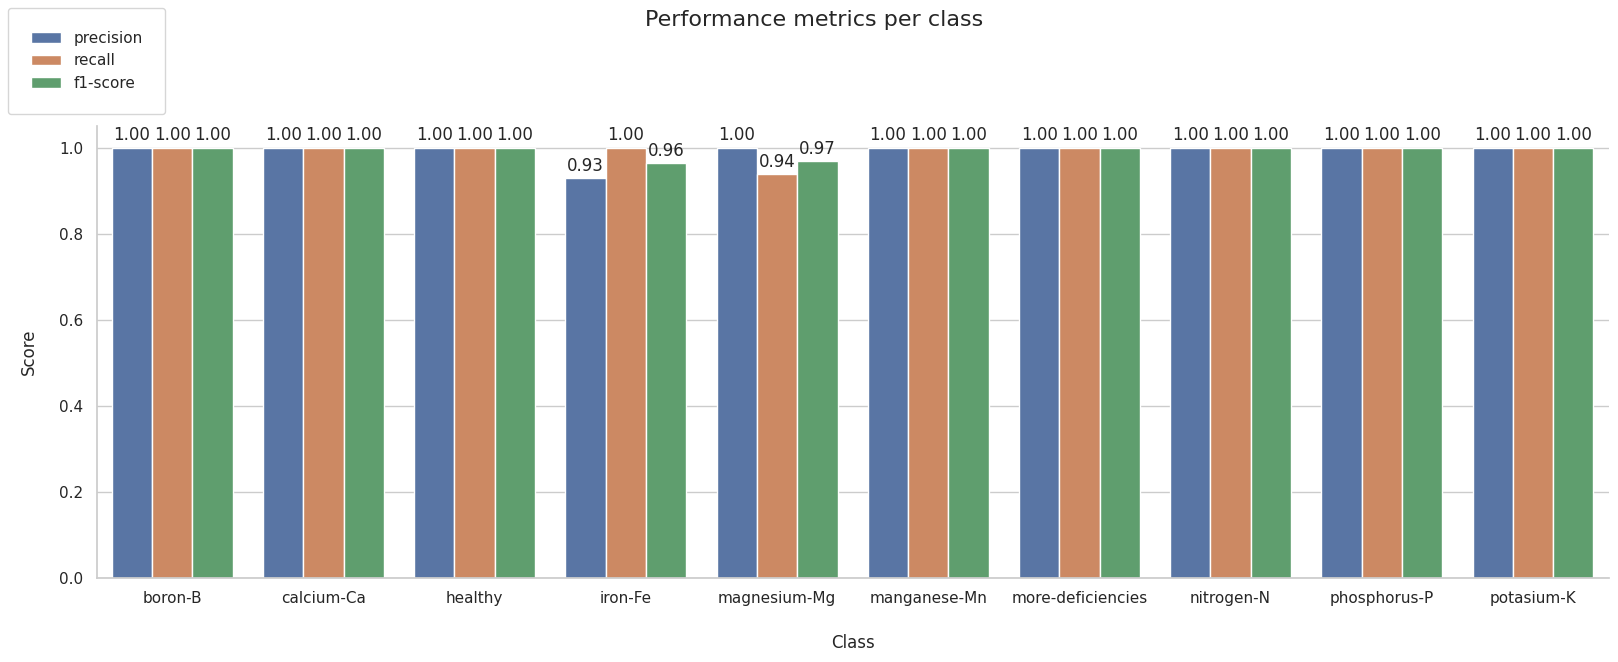

In [38]:
df_class_metrics = df_report[:-3]

df_melted = pd.melt(
    df_class_metrics,
    id_vars=['class'],
    value_vars=['precision', 'recall', 'f1-score'],
    var_name='Metric',
    value_name='Score'
)

g = sns.catplot(
    data=df_melted,
    kind="bar",
    x="class",
    y="Score",
    hue="Metric",
    aspect=2.5,
    height=6
)

g.figure.suptitle('Performance metrics per class', fontsize=16, y=1.1)

sns.move_legend(g, "upper left", borderpad=1.5, title=None, frameon=True)
sns.set_theme(style="whitegrid")

for ax in g.axes.flat:
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')

plt.xlabel("Class", labelpad=20)
plt.ylabel("Score", labelpad=15)
plt.tight_layout()
plt.savefig(os.path.join(GRAPHS_OUTPUT, f"metrics_barchart_{MODEL_VERSION}.png"))
plt.show()

##### F1 Score vs. Class Proportion

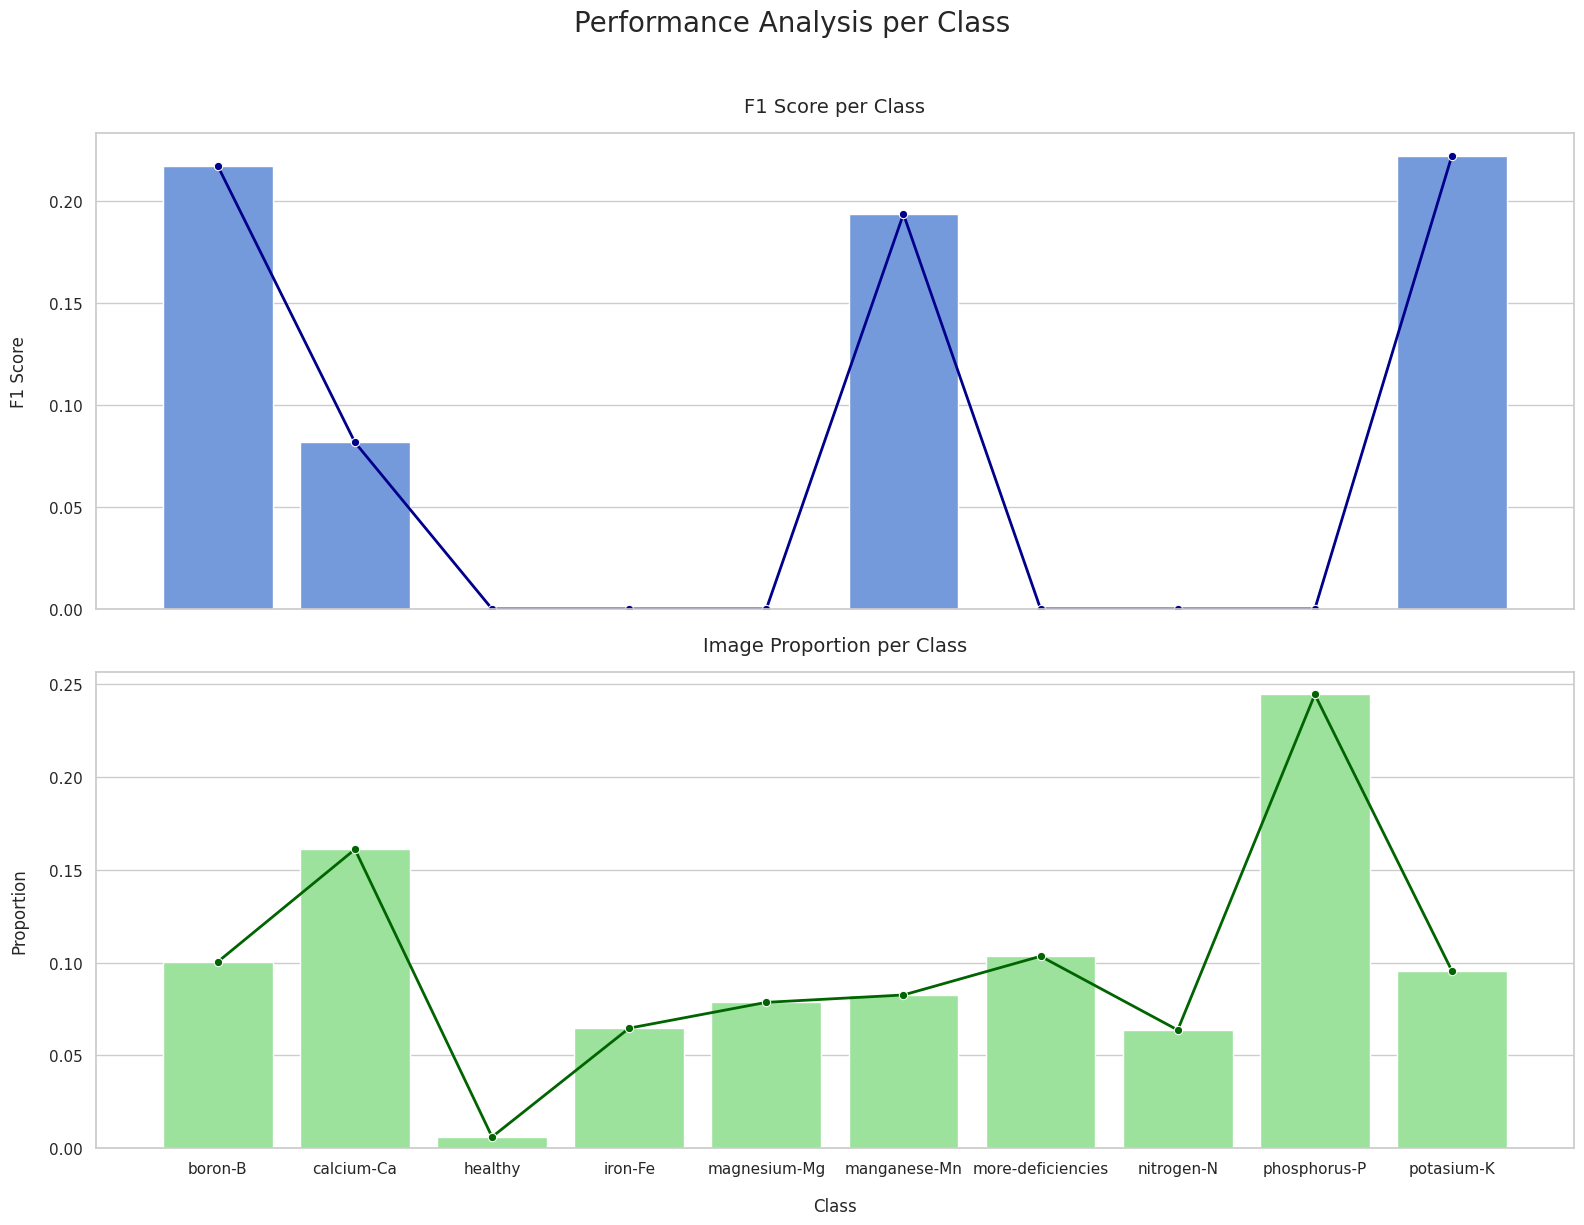

In [14]:
df_f1 = df_report.iloc[:-3, :][['f1-score']].copy()

total_images = len(class_labels)
image_counts = [class_labels.count(i) for i in range(len(classes))]
image_proportions = [count / total_images for count in image_counts]

df_plot_data = pd.DataFrame({
    'Class': classes,
    'F1 Score': df_f1['f1-score'].values,
    'Image Proportion': image_proportions
})

fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
fig.suptitle('Performance Analysis per Class', fontsize=20, y=1.02)

ax1 = axes[0]
sns.barplot(
    data=df_plot_data,
    x='Class',
    y='F1 Score',
    color='cornflowerblue',
    ax=ax1
)
sns.lineplot(
    data=df_plot_data,
    x='Class',
    y='F1 Score',
    color='darkblue',
    marker='o',
    linewidth=2,
    ax=ax1
)
ax1.set_title('F1 Score per Class', fontsize=14, pad=15)
ax1.set_ylabel('F1 Score', labelpad=15)
ax1.set_xlabel('')

ax2 = axes[1]
sns.barplot(
    data=df_plot_data,
    x='Class',
    y='Image Proportion',
    color='lightgreen',
    ax=ax2
)
sns.lineplot(
    data=df_plot_data,
    x='Class',
    y='Image Proportion',
    color='darkgreen',
    marker='o',
    linewidth=2,
    ax=ax2
)
ax2.set_title('Image Proportion per Class', fontsize=14, pad=15)
ax2.set_ylabel('Proportion', labelpad=15)
ax2.set_xlabel('Class', labelpad=15)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, f"graphs/f1_vs_class_proportion_{MODEL_VERSION}.png"))
plt.show()

#### Confusion Matrix

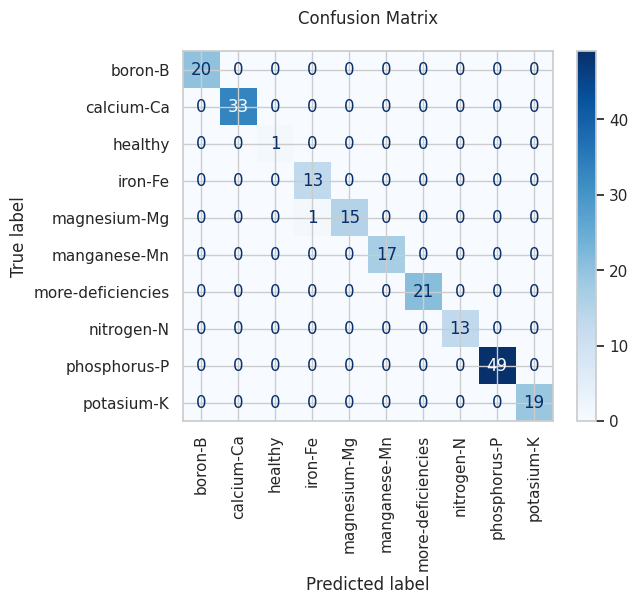

In [39]:
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes).plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix', pad=20)
plt.savefig(os.path.join(GRAPHS_OUTPUT, f"confusion_matrix_{MODEL_VERSION}.png"))

#### ROC Curve

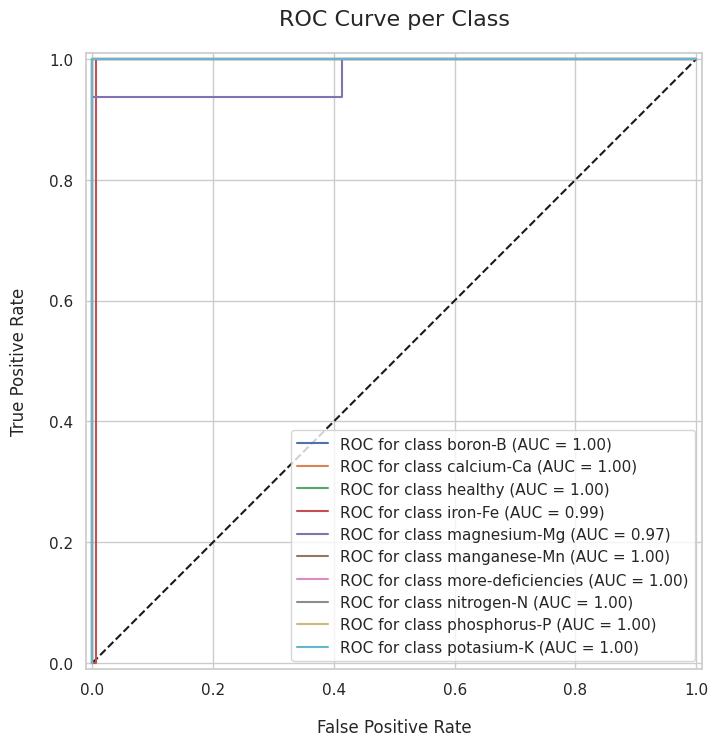

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the "no-skill" line for reference
ax.plot([0, 1], [0, 1], linestyle="--", color="k")

for i in range(len(dataset.classes)):
    RocCurveDisplay.from_predictions(
        y_true[:, i],
        all_probs[:, i],
        name=f"ROC for class {dataset.classes[i]}",
        ax=ax
    )

ax.set_xlabel("False Positive Rate", labelpad=15)
ax.set_ylabel("True Positive Rate", labelpad=15)
ax.set_title("ROC Curve per Class", fontsize=16, pad=20)
ax.legend(loc="lower right")
ax.grid(True)
plt.savefig(os.path.join(GRAPHS_OUTPUT, f"roc_curve_display_{MODEL_VERSION}.png"))
plt.show()